In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
try:
    df = pd.read_excel("Bibliometric_study.xlsx")  # Replace with your actual file name
except FileNotFoundError:
    print("Error: 'Bibliometric_study.xlsx' not found.  Make sure the file exists in the correct directory.")
    exit()

In [7]:
# Clean up 'Number of simulations' column and convert to numeric
try:
    df['Number of simulations'] = pd.to_numeric(df['Number of simulations'], errors='coerce')
    df.dropna(subset=['Number of simulations'], inplace=True)  # Remove rows where conversion failed
    df['Number of simulations'] = df['Number of simulations'].astype(int) # Convert to int after cleaning
except KeyError:
    print("Error: 'Number of simulations' column not found.")
    exit()
except ValueError:
    print("Error: Unable to convert 'Number of simulations' to numeric.  Check data for non-numeric entries.")
    exit()

In [8]:
import re

def extract_info(reference_string):
    """Extracts publisher and year from a reference string, handling spaces and potential NaN values."""
    publisher = "Unknown"  # Default to "Unknown"
    year = None

    if isinstance(reference_string, str):  # Only process if it's a string

        # Publisher extraction (handle extra spaces)
        match = re.search(r'publisher\s*=\s*{(.*?)}', reference_string)  # Non-greedy match
        if match:
            publisher = match.group(1).strip()  # Extract and strip spaces

        # Year extraction using regex (handle extra spaces)
        year_match = re.search(r'year\s*=\s*{\s*(\d{4})\s*}', reference_string) # Regex with space tolerance
        if year_match:
            year = int(year_match.group(1))  # Convert to integer

    return publisher, year

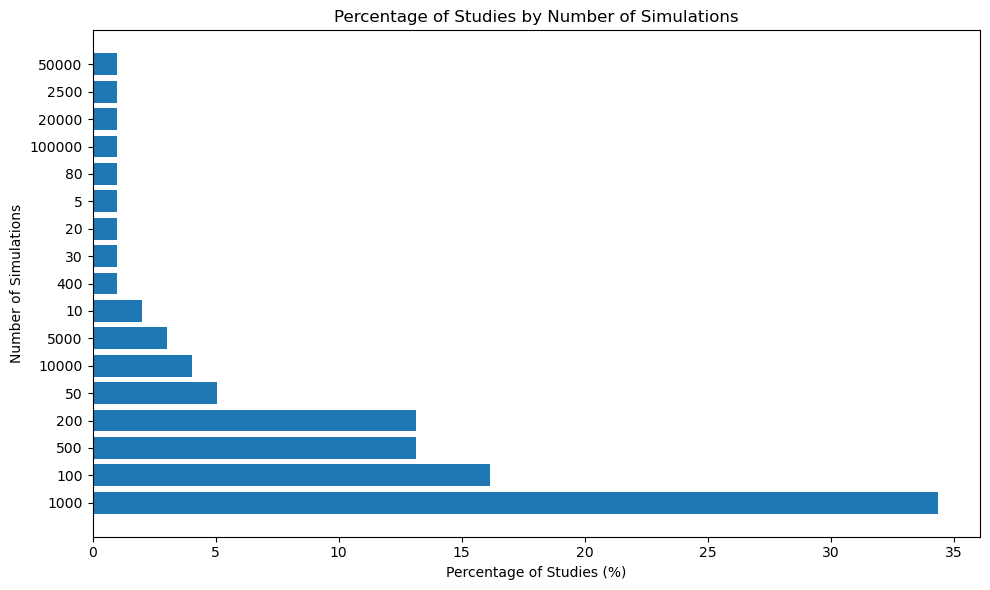

In [9]:
# Apply the function to create new columns
df[['Publisher', 'Year']] = df['Reference'].apply(lambda x: pd.Series(extract_info(x)))


simulation_counts = df['Number of simulations'].astype(str).value_counts(normalize=True) * 100
sorted_simulation_counts = simulation_counts.sort_values(ascending=False) # Sorting happens here

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(sorted_simulation_counts.index, sorted_simulation_counts.values) #  x-axis: sorted counts, y-axis: labels
plt.xlabel('Percentage of Studies (%)')
plt.ylabel('Number of Simulations')
plt.title('Percentage of Studies by Number of Simulations')
plt.tight_layout()
plt.savefig('chart1_simulations_percentage_horizontal_string_sorted.png')
plt.show()


In [57]:
sorted_simulation_counts.index

Index(['1000', '500', '200', '100', '50', '10000', '5000', '10', '400', '20',
       '30', '100000', '20000', '2500', '50000'],
      dtype='object', name='Number of simulations')

In [59]:
print(f"Percentage of papers that would be considered insufficient if we would use a 1000 simulations as the standard: {round((16.16161616+13.13131313+13.13131313+5.05050505+2.02020202+1.01010101+1.01010101+1.01010101+1.01010101),2)}%")

Percentage of papers that would be considered insufficient if we would use a 1000 simulations as the standard: 53.54%


In [53]:
sorted_simulation_counts.values

array([34.34343434, 16.16161616, 13.13131313, 13.13131313,  5.05050505,
        4.04040404,  3.03030303,  2.02020202,  1.01010101,  1.01010101,
        1.01010101,  1.01010101,  1.01010101,  1.01010101,  1.01010101,
        1.01010101,  1.01010101])

In [11]:
from matplotlib.patches import Patch # Needed for custom legend entries

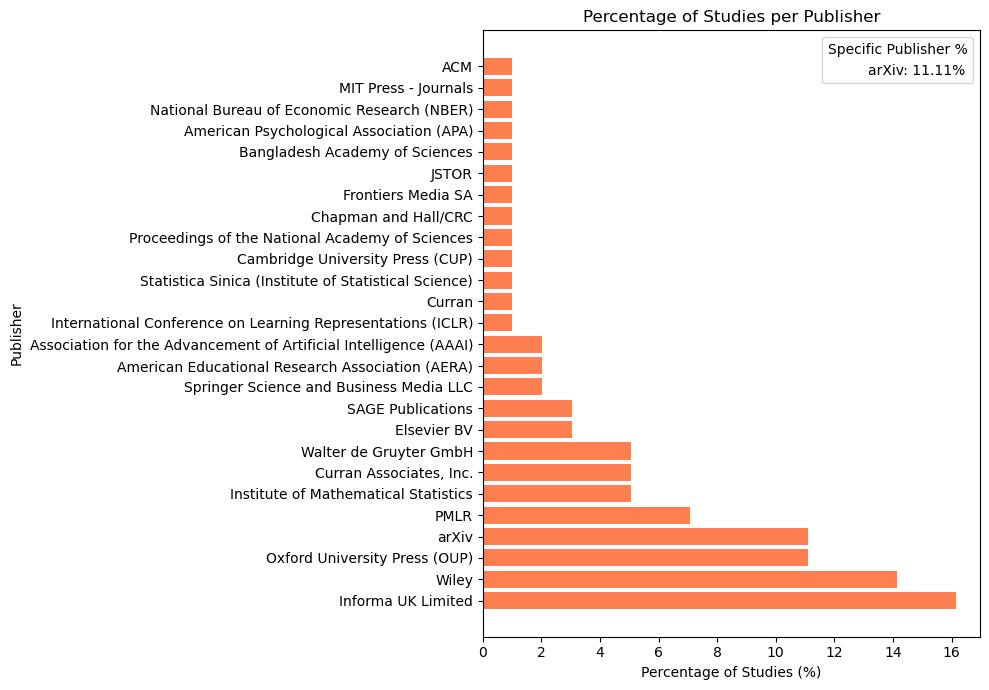


Percentage of studies with Publisher 'arXiv': 11.11%


In [12]:
cleaned_publishers = df['Publisher']

if cleaned_publishers.empty:
    print("No non-NaN publisher data found. Cannot generate Publisher chart.")
    publisher_counts = pd.Series(dtype=float) # Empty series for downstream checks
    perc_arxiv = 0.0
else:
    publisher_counts = cleaned_publishers.value_counts(normalize=True) * 100 # Calculate percentages

    # 2. Calculate arXiv Percentage Separately
    #    Use .get() to safely handle cases where 'arXiv' might not be present
    perc_arxiv = publisher_counts.get('arXiv', 0.0)

# 3. Plotting
plt.figure(figsize=(10, 7)) # Slightly taller to accommodate legend if many publishers

if not publisher_counts.empty:
    plt.barh(publisher_counts.index, publisher_counts.values, color='coral') # Assign a color
else:
     plt.text(0.5, 0.5, 'No publisher data available to plot',
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes)

plt.xlabel('Percentage of Studies (%)')
plt.ylabel('Publisher')
plt.title('Percentage of Studies per Publisher')

# 4. Create Custom Legend for arXiv Percentage
legend_elements = [
    Patch(facecolor='none', edgecolor='none', # Invisible patch
          label=f'arXiv: {perc_arxiv:.2f}%')
]

# Add the legend only if there's data
if not publisher_counts.empty:
    plt.legend(handles=legend_elements, title="Specific Publisher %", loc='best')

plt.tight_layout()
plt.savefig('chart2_publisher_percentage_with_arxiv.png')
plt.show()

print(f"\nPercentage of studies with Publisher 'arXiv': {perc_arxiv:.2f}%")

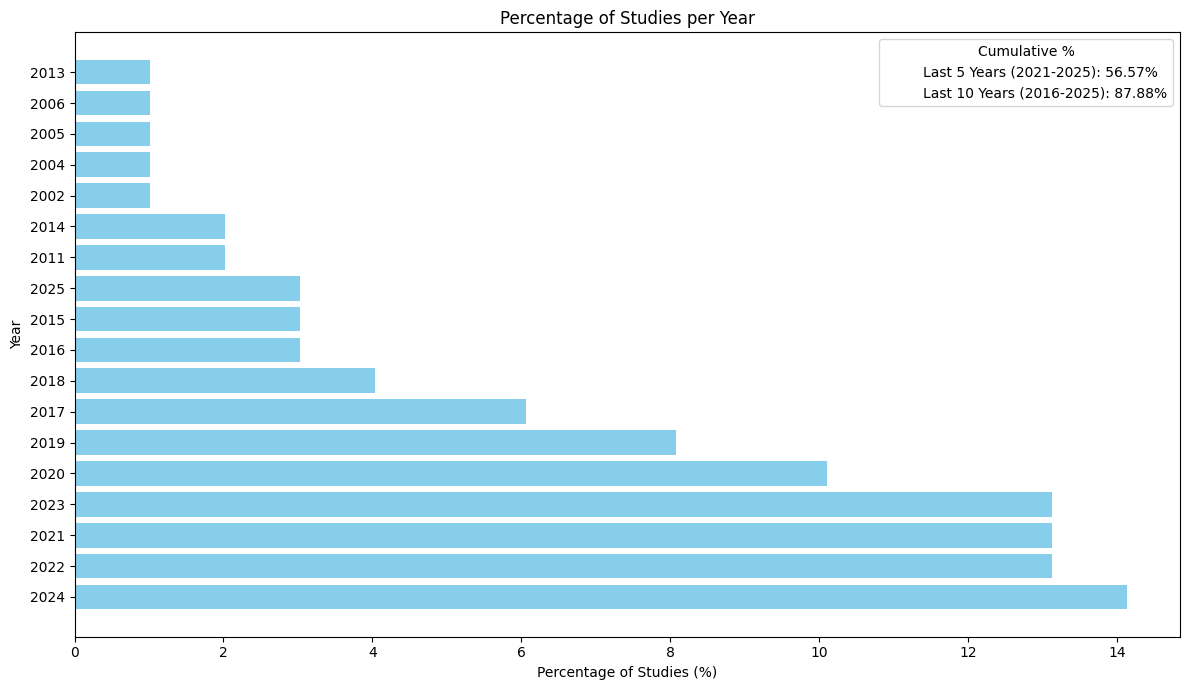


Calculated Percentages:
Last 5 Years (2021 - 2025): 56.57%
Last 10 Years (2016 - 2025): 87.88%


In [43]:
# 1. Handle potential non-numeric or NaN years before calculations
#    Convert to numeric, coercing errors to NaN, then drop NaNs
numeric_years = pd.to_numeric(df['Year'], errors='coerce').dropna()

# Check if there are any valid years left
if numeric_years.empty:
    print("No valid numeric years found in the 'Year' column. Cannot generate plot.")
    # Optionally: exit() or raise ValueError("No valid years")
    # For this example, create dummy data to avoid crashing downstream code
    year_counts = pd.Series(dtype=float)
    sorted_year_counts = pd.Series(dtype=float)
    max_year = None
else:
    # Convert valid years to integer (optional, but good practice)
    numeric_years = numeric_years.astype(int)

    # Calculate percentages (use the cleaned numeric_years)
    # Convert to string *after* cleaning for value_counts index
    year_counts = numeric_years.astype(str).value_counts(normalize=True) * 100
    sorted_year_counts = year_counts.sort_values(ascending=False)

    # Find the latest year present in the data
    max_year = numeric_years.max() # Use the numeric version

# --- Calculate Cumulative Percentages ---
perc_last_5 = 0.0
perc_last_10 = 0.0

# Ensure we have data and a max_year to calculate from
if max_year is not None and not sorted_year_counts.empty:
    # Define year thresholds
    year_threshold_5 = max_year - 4  # Last 5 years are max_year down to max_year-4
    year_threshold_10 = max_year - 9 # Last 10 years are max_year down to max_year-9

    # Iterate through the calculated percentages (index is year as string)
    for year_str, percentage in sorted_year_counts.items():
        try:
            year_int = int(year_str)
            if year_int >= year_threshold_5:
                perc_last_5 += percentage
            if year_int >= year_threshold_10:
                perc_last_10 += percentage
        except ValueError:
            # Should not happen if input was cleaned, but safety check
            print(f"Warning: Could not convert year '{year_str}' to integer.")
            continue # Skip this entry


# --- Plotting ---
plt.figure(figsize=(12, 7)) # Slightly wider to accommodate legend

# Check if there's data to plot
if not sorted_year_counts.empty:
    plt.barh(sorted_year_counts.index, sorted_year_counts.values, color='skyblue') # Assign a color
else:
    # Handle case with no data: display an empty plot with a message
    plt.text(0.5, 0.5, 'No data available to plot',
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes) # Use axes coordinates

plt.xlabel('Percentage of Studies (%)')
plt.ylabel('Year') # Keep label simple ('as String' is implied by the ticks)
plt.title('Percentage of Studies per Year')

# --- Create Custom Legend ---
# Only add legend elements if percentages were calculated
legend_elements = []
if max_year is not None:
     legend_elements = [
         Patch(facecolor='none', edgecolor='none', # Invisible patch
               label=f'Last 5 Years ({year_threshold_5}-{max_year}): {perc_last_5:.2f}%'),
         Patch(facecolor='none', edgecolor='none', # Invisible patch
               label=f'Last 10 Years ({year_threshold_10}-{max_year}): {perc_last_10:.2f}%')
     ]

# Add the legend to the plot if there are elements to show
if legend_elements:
    plt.legend(handles=legend_elements, title="Cumulative %", loc='best') # Add title and let matplotlib place it

plt.tight_layout()
plt.savefig('chart3_year_percentage_with_summary.png')
plt.show()

print(f"\nCalculated Percentages:")
print(f"Last 5 Years ({max_year-4 if max_year else 'N/A'} - {max_year if max_year else 'N/A'}): {perc_last_5:.2f}%")
print(f"Last 10 Years ({max_year-9 if max_year else 'N/A'} - {max_year if max_year else 'N/A'}): {perc_last_10:.2f}%")

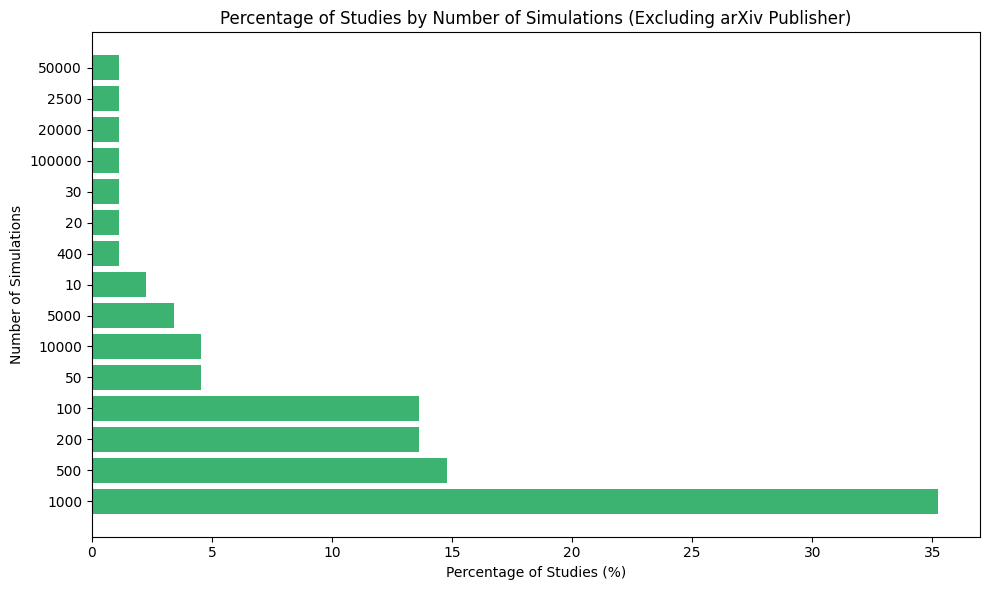

In [54]:
df_filtered = df[df['Publisher'] != 'arXiv']

# Check if the filtered DataFrame is empty
if df_filtered.empty:
    print("No data remaining after filtering out 'arXiv' publishers.")
    sorted_simulation_counts = pd.Series(dtype=float) # Empty series for plot check
else:
    # 2. Select and Clean Simulation Data from the FILTERED DataFrame
    #    Handle potential NaNs and convert to string for counting categories
    simulations_filtered = df_filtered['Number of simulations'].dropna().astype(str)

    if simulations_filtered.empty:
        print("No non-NaN simulation data found in the filtered DataFrame.")
        sorted_simulation_counts = pd.Series(dtype=float) # Empty series for plot check
    else:
        # 3. Calculate and Sort Percentages
        simulation_counts = simulations_filtered.value_counts(normalize=True) * 100
        sorted_simulation_counts = simulation_counts.sort_values(ascending=False)

# 4. Create horizontal bar chart
plt.figure(figsize=(10, 6))

if not sorted_simulation_counts.empty:
    plt.barh(sorted_simulation_counts.index, sorted_simulation_counts.values, color='mediumseagreen') # Use filtered counts
else:
    plt.text(0.5, 0.5, 'No simulation data available to plot (after filtering)',
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes)

plt.xlabel('Percentage of Studies (%)')
plt.ylabel('Number of Simulations')
# Update title to reflect the filtering
plt.title('Percentage of Studies by Number of Simulations (Excluding arXiv Publisher)')
plt.tight_layout()
plt.savefig('chart1_simulations_percentage_non_arxiv.png')
plt.show()

In [56]:
sorted_simulation_counts.index

Index(['1000', '500', '200', '100', '50', '10000', '5000', '10', '400', '20',
       '30', '100000', '20000', '2500', '50000'],
      dtype='object', name='Number of simulations')

In [55]:
sorted_simulation_counts.values

array([35.22727273, 14.77272727, 13.63636364, 13.63636364,  4.54545455,
        4.54545455,  3.40909091,  2.27272727,  1.13636364,  1.13636364,
        1.13636364,  1.13636364,  1.13636364,  1.13636364,  1.13636364])

In [60]:
print(f"Percentage of papers that would be considered insufficient if we would use a 1000 simulations as the standard: {round((14.77272727+13.63636364+13.63636364+4.54545455+2.27272727+1.13636364+1.13636364+1.13636364+1.13636364),2)}%")

Percentage of papers that would be considered insufficient if we would use a 1000 simulations as the standard: 53.41%
